## 시계열 데이터 예측 모델링

In [2]:
import numpy as np #linear algebra
import pandas as pd #data processing , csv file I/o

import seaborn as sns # visualization
import matplotlib.pyplot as plt #visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import warnings #supress warnings

In [3]:
df = pd.read_csv('data/Aquifer_Petrignano.csv')

In [4]:
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  5223 non-null   object 
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64
 2   Depth_to_Groundwater_P24              5168 non-null   float64
 3   Depth_to_Groundwater_P25              5184 non-null   float64
 4   Temperature_Bastia_Umbra              4199 non-null   float64
 5   Temperature_Petrignano                4199 non-null   float64
 6   Volume_C10_Petrignano                 5025 non-null   float64
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64
dtypes: float64(7), object(1)
memory usage: 326.6+ KB


날짜, 강수량, 지하수 깊이, 온도, 천연가스 체적, 수위 등의 다양한 지표를 포함하고 있으며, 
각각의 열은 해당 날짜에 관련된 값들을 기록. > 몇몇 열에는 결측값이 존재함 

In [6]:
df = df[df.Rainfall_Bastia_Umbra.notna()] # Rainfall_Bastia_Umbra가 결측값이 아닌 행들만 선택
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)
df.columns = ['Date', 'Rainfall', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry']

targets = ['Depth_to_Groundwater']
features = [feature for feature in df.columns if feature not in targets]

In [7]:
df.head()

,Date,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
1024,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1025,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
1026,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
1027,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
1028,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


In [8]:
from datetime import datetime,date
df['Date'] = pd.to_datetime(df.Date, format = '%d/%m/%Y')

In [9]:
df.head().style.set_properties(subset = ['Date'], **{'background-color':'dodgerblue'})

,Date,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
1024,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1025,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
1026,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
1027,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
1028,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


### 결측치 시각화

#### 1. fillna(np.inf) 단순 시각화

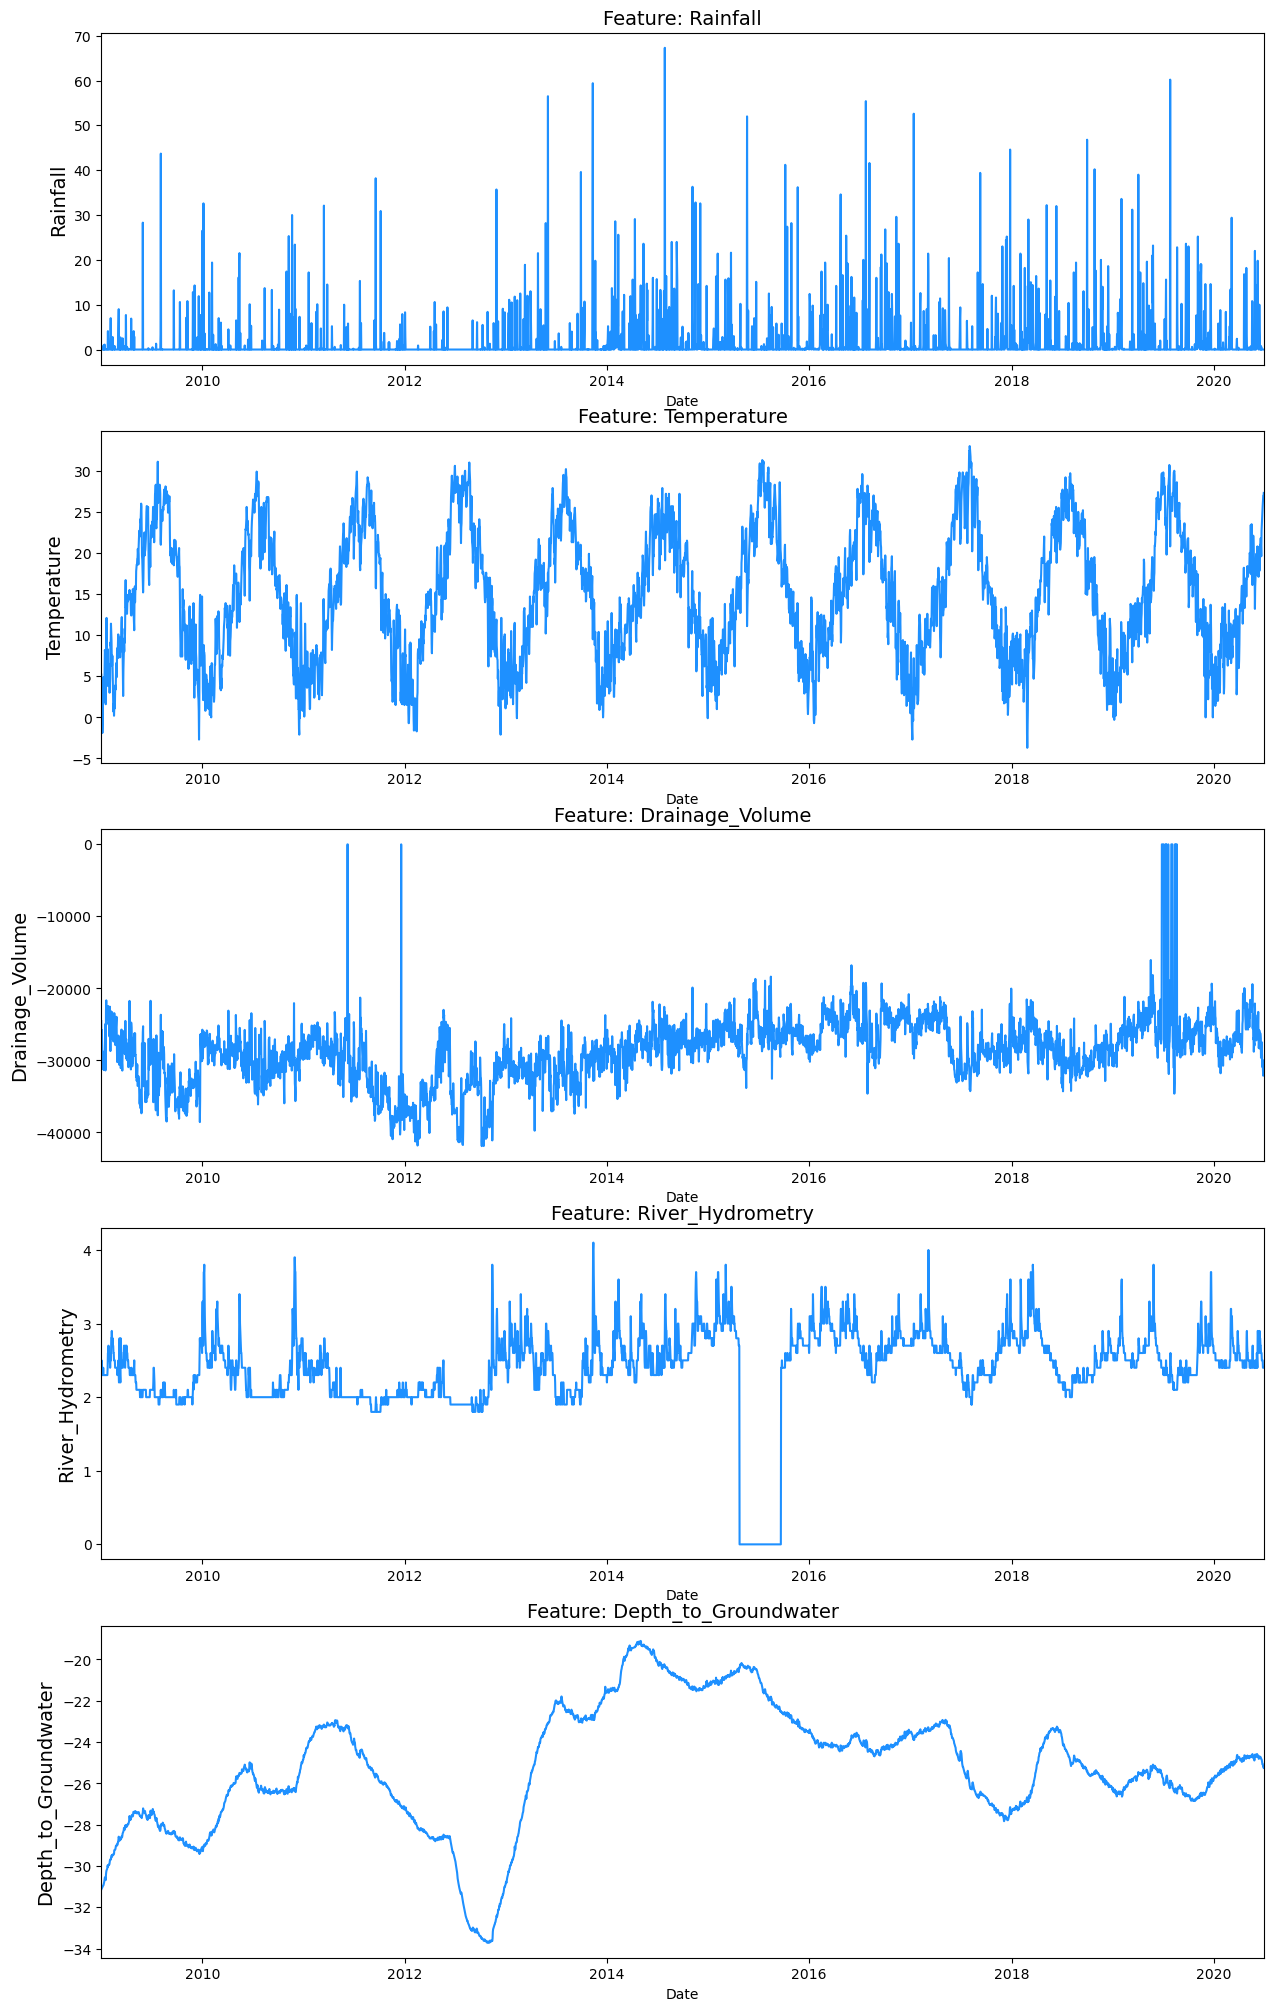

In [10]:
def plot_features_and_target(df):
    f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

    features = ['Rainfall', 'Temperature', 'Drainage_Volume', 'River_Hydrometry', 'Depth_to_Groundwater']

    for i, feature in enumerate(features):
        sns.lineplot(x=df.Date, y=df[feature].fillna(np.inf), ax=ax[i], color='dodgerblue')
        ax[i].set_title(f'Feature: {feature}', fontsize=14)
        ax[i].set_ylabel(ylabel=feature, fontsize=14)
        ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

    plt.show()

# 호출
plot_features_and_target(df)


River_Hydrometry, Drainage_volumn 에서 결측값 발생 확인

In [11]:
#sort_values
df = df.sort_values(by = 'Date')

In [12]:
df

,Date,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
1024,2009-01-01,0.0,-31.14,5.2,-24530.688,2.4
1025,2009-01-02,0.0,-31.11,2.3,-28785.888,2.5
1026,2009-01-03,0.0,-31.07,4.4,-25766.208,2.4
1027,2009-01-04,0.0,-31.05,0.8,-27919.296,2.4
1028,2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3
...,...,...,...,...,...,...
5218,2020-06-26,0.0,-25.07,25.7,-29930.688,2.5
5219,2020-06-27,0.0,-25.11,26.2,-31332.960,2.4
5220,2020-06-28,0.0,-25.19,26.9,-32120.928,2.4
5221,2020-06-29,0.0,-25.18,26.9,-30602.880,2.4


In [13]:
df['Time_Interval'] = df.Date - df.Date.shift(1) #shift(1) 해당열의 값을 하나 밑의 행 값으로 바꿈
df[['Date','Time_Interval']].head()

,Date,Time_Interval
1024,2009-01-01,NaT
1025,2009-01-02,1 days
1026,2009-01-03,1 days
1027,2009-01-04,1 days
1028,2009-01-05,1 days


In [14]:
df['Time_Interval'].value_counts()

1 days    4198
Name: Time_Interval, dtype: int64

#### 2. River_Hydrometry, Drainage_volumn 시각화

<Axes: xlabel='Date', ylabel='Drainage_Volume'>

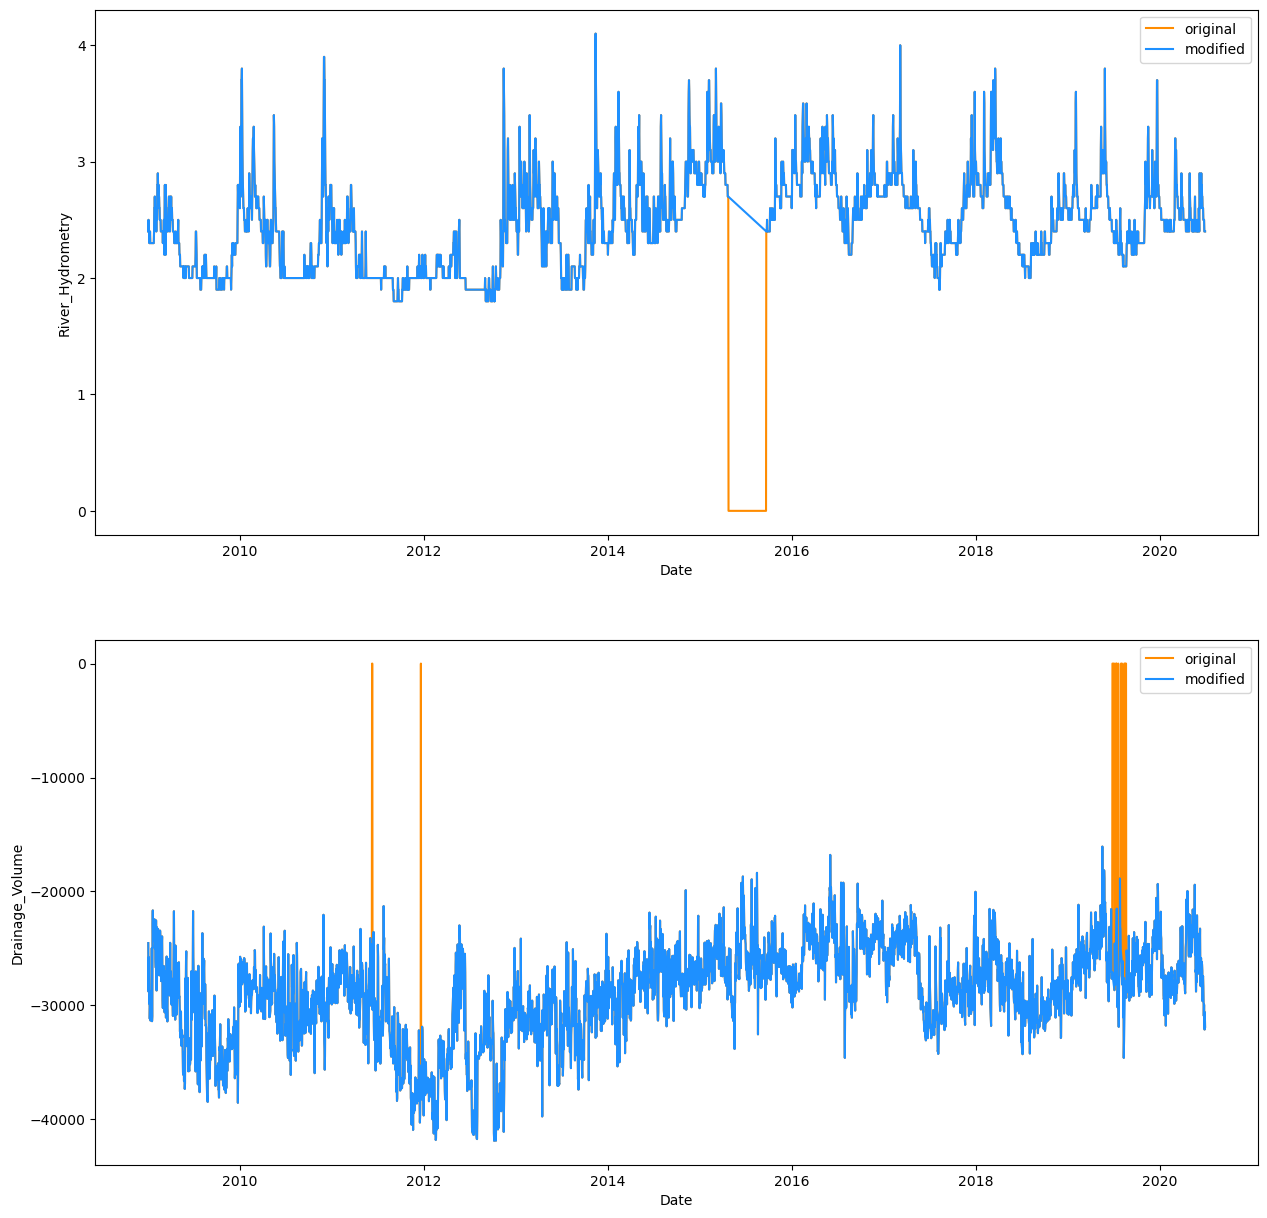

In [15]:
f, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (15,15))
old = df.River_Hydrometry.copy()
df['River_Hydrometry'] = np.where(df.River_Hydrometry == 0, np.nan, df.River_Hydrometry) # 0이면 nan 값으로 간주함

sns.lineplot(x = df.Date, y = old.fillna(np.inf), ax = ax[0], color = 'darkorange', label = 'original')
sns.lineplot(x = df.Date, y = df.River_Hydrometry.fillna(np.inf), ax = ax[0], color = 'dodgerblue', label = 'modified')

old = df.Drainage_Volume.copy()
df['Drainage_Volume'] = np.where(df.Drainage_Volume == 0, np.nan, df.Drainage_Volume) # 0이면 nan 값으로 간주함

sns.lineplot(x = df.Date, y = old.fillna(np.inf), ax = ax[1], color = 'darkorange', label = 'original')
sns.lineplot(x = df.Date, y = df.Drainage_Volume.fillna(np.inf), ax = ax[1], color = 'dodgerblue', label = 'modified')


#### 3. Heatmap으로 결측치 시각화

/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_2306/1134307215.py:6: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(13)


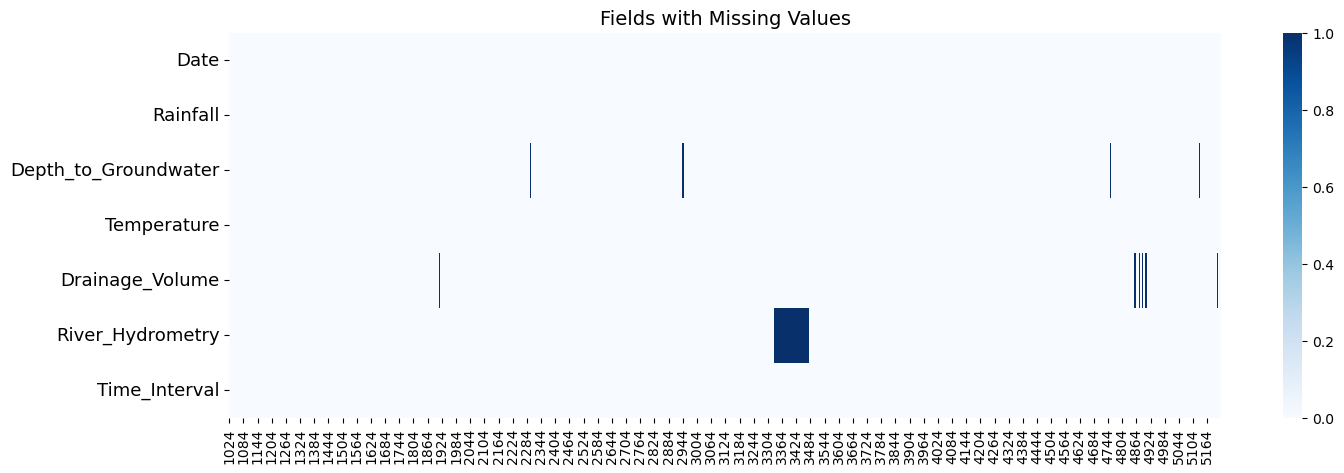

In [21]:
f, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (16,5))
sns.heatmap(df.T.isna(), cmap = 'Blues') # df.T.isna()는 데이터프레임을 전치한 후, 각 요소가 결측값인지 여부를 나타내는 불리언(True/False) 값의 행렬을 생성
ax.set_title('Fields with Missing Values', fontsize = 14)

# y축의 주요 눈금에 대한 레이블의 폰트 크기를 13으로 설정
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(13)
plt.show()

### 결측치 대체

#### Drainage 결측값 대체 케이스 별 시각화

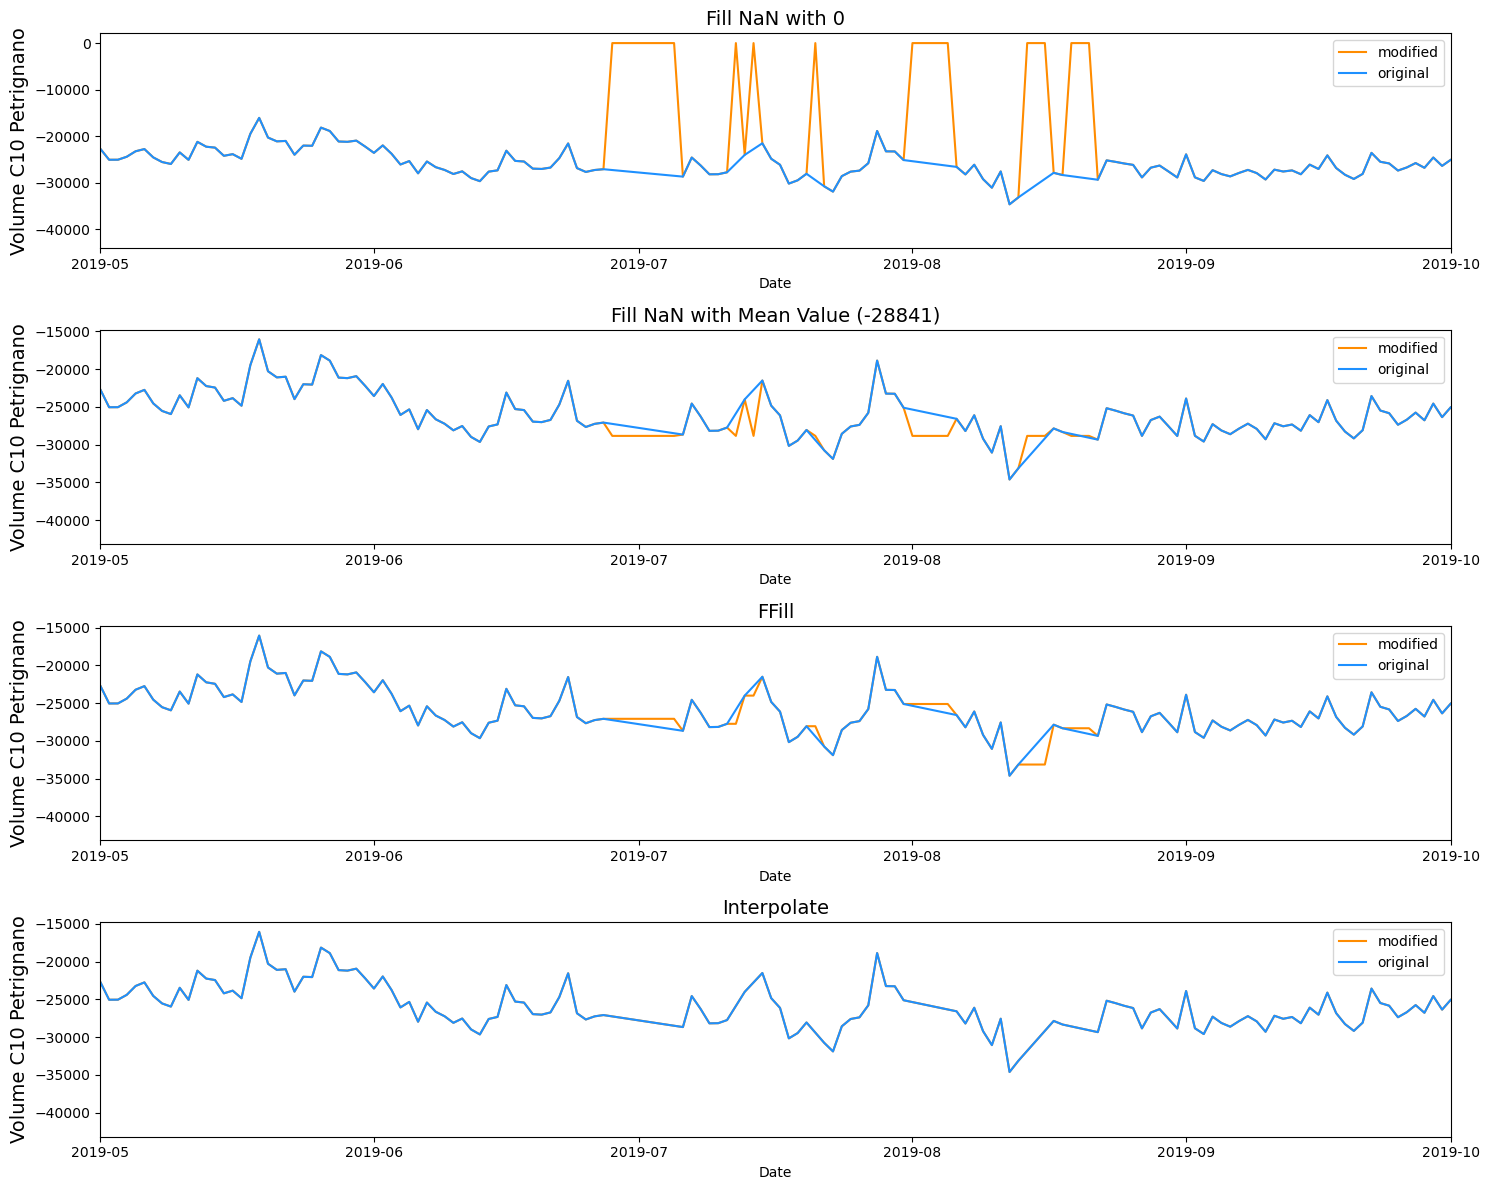

In [22]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(0), ax=ax[0], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

mean_val = df.Drainage_Volume.mean()
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(mean_val), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_val:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df.Date, y=df.Drainage_Volume.ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df.Date, y=df.Drainage_Volume.interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])
plt.tight_layout()
plt.show()

In [24]:
# 보간법 사용해서 대체
df['Drainage_Volume'] = df['Drainage_Volume'].interpolate()
df['River_Hydrometry'] = df['River_Hydrometry'].interpolate()
df['Depth_to_Groundwater'] = df['Depth_to_Groundwater'].interpolate()

### resample 경향성 확인

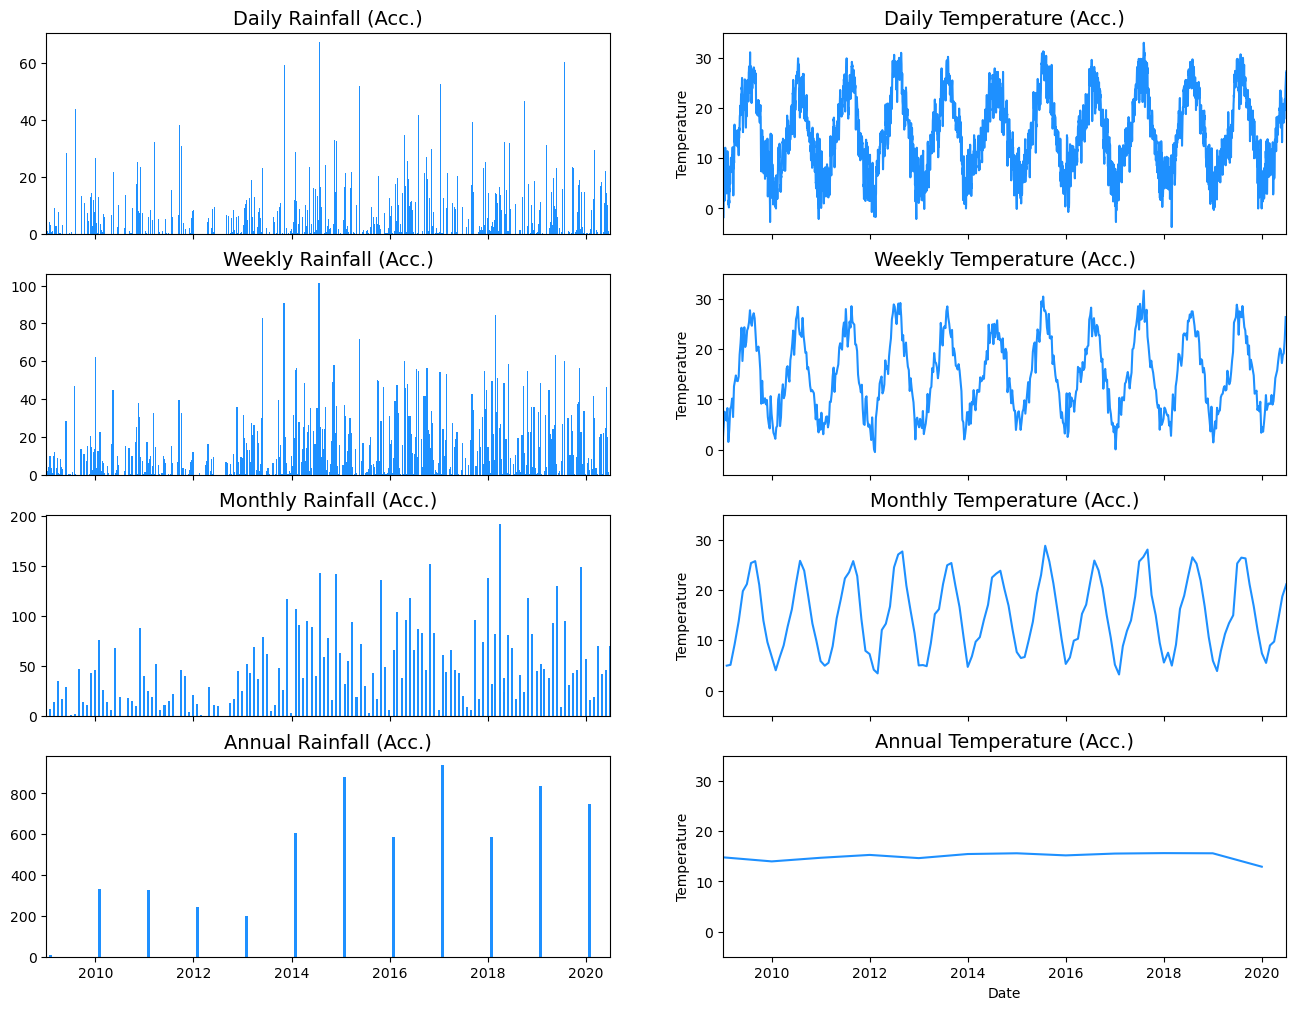

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

# Assuming df is your DataFrame

fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16, 12))

ax[0, 0].bar(df.Date, df.Rainfall, width=5, color='dodgerblue')
ax[0, 0].set_title('Daily Rainfall (Acc.)', fontsize=14)

resampled_df = df[['Date', 'Rainfall']].resample('7D', on='Date').sum().reset_index(drop=False)
ax[1, 0].bar(resampled_df['Date'], resampled_df['Rainfall'], width=10, color='dodgerblue')
ax[1, 0].set_title('Weekly Rainfall (Acc.)', fontsize=14)

resampled_df = df[['Date', 'Rainfall']].resample('M', on='Date').sum().reset_index(drop=False)
ax[2, 0].bar(resampled_df['Date'], resampled_df['Rainfall'], width=15, color='dodgerblue')
ax[2, 0].set_title('Monthly Rainfall (Acc.)', fontsize=14)

resampled_df = df[['Date', 'Rainfall']].resample('12M', on='Date').sum().reset_index(drop=False)
ax[3, 0].bar(resampled_df['Date'], resampled_df['Rainfall'], width=20, color='dodgerblue')
ax[3, 0].set_title('Annual Rainfall (Acc.)', fontsize=14)

for i in range(4):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(x=df['Date'], y=df['Temperature'], color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Daily Temperature (Acc.)', fontsize=14)

resampled_df = df[['Date', 'Temperature']].resample('7D', on='Date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df['Date'], y=resampled_df['Temperature'], color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Temperature (Acc.)', fontsize=14)

resampled_df = df[['Date', 'Temperature']].resample('M', on='Date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df['Date'], y=resampled_df['Temperature'], color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Temperature (Acc.)', fontsize=14)

resampled_df = df[['Date', 'Temperature']].resample('365D', on='Date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df['Date'], y=resampled_df['Temperature'], color='dodgerblue', ax=ax[3, 1])
ax[3, 1].set_title('Annual Temperature (Acc.)', fontsize=14)

for i in range(4):
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_ylim([-5, 35])

plt.show()
